# IBM Capstone Project

## Battle of the Neighborhood - Part 2

## 1. Data Preparation

### Installing package & libraries

In [1]:
!pip install folium

In [2]:
!pip install beautifulsoup4

In [3]:
import numpy as np
import pandas as pd

import requests
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
from geopy.geocoders import Nominatim
import folium
from pandas.io.json import json_normalize


#Import data from HTML
from bs4 import BeautifulSoup

#Data Analysis 
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, r2_score
import itertools


print('Libraries imported!')

Libraries imported!


### Import Dataset from Government Data

In [4]:
!pip install sodapy

In [5]:
#!/usr/bin/env python

# make sure to install these packages before running:
# pip install pandas
# pip install sodapy

import pandas as pd
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofnewyork.us,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("43nn-pn8j", limit=2000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In this research, we will obtain a random sample of 2000 observations from the data sources.

In [6]:
results_df
print(results_df.shape)
results_df.head()

(2000, 26)


,action,bbl,bin,boro,building,camis,census_tract,community_board,council_district,critical_flag,...,latitude,longitude,nta,phone,record_date,score,street,violation_code,violation_description,zipcode
0,Violations were cited in the following area(s).,3020200074,3057892,Brooklyn,1057,50061005,022700,303,36,N,...,40.679497045729,-73.956678161648,BK69,9177103926,2020-03-27T06:01:34.000,10,ATLANTIC AVE,08A,Facility not vermin proof. Harborage or condit...,11238
1,Violations were cited in the following area(s).,1021610004,1063864,Manhattan,1618,41615115,027700,112,10,N,...,40.855449723566,-73.929230693936,MN35,2127811880,2020-03-27T06:01:34.000,12,ST NICHOLAS AVENUE,08A,Facility not vermin proof. Harborage or condit...,10040
2,Violations were cited in the following area(s).,2039460001,2041210,Bronx,2109,50052857,022200,209,18,N,...,40.836087020288,-73.854798477127,BX46,7189047061,2020-03-27T06:01:34.000,38,STARLING AVE,10B,Plumbing not properly installed or maintained;...,10462
3,Violations were cited in the following area(s).,4015420031,4539828,Queens,8313,50094666,047300,404,25,N,...,40.737216817441,-73.879700416899,QN29,7188990240,2020-03-27T06:01:34.000,11,QUEENS BLVD,10C,Lighting inadequate; permanent lighting not pr...,11373
4,Violations were cited in the following area(s).,1005390019,1008674,Manhattan,82,50074487,006500,102,01,Y,...,40.729786679496,-73.998841807199,MN23,2128033369,2020-03-27T06:01:34.000,26,W 3RD ST,04N,Filth flies or food/refuse/sewage-associated (...,10012


### Data Cleaning

After obtaining the dataset, we have to remove non-assigned observations and unimportant variables, and create a new categorical variables. The final data set comprises of 1003 restaurants. 

We create a new category to better classify the restaurants based on the origin types.

In [7]:
nyc_data = results_df.drop(["action","bbl","bin","census_tract","community_board","council_district","nta","phone","record_date","street","inspection_type","grade_date","inspection_date","violation_code"],axis=1)
nyc_data.rename(columns = {'latitude':'lat', 'longitude':'lng'}, inplace = True)
print(nyc_data.columns) 

Index(['boro', 'building', 'camis', 'critical_flag', 'cuisine_description',
       'dba', 'grade', 'lat', 'lng', 'score', 'violation_description',
       'zipcode'],
      dtype='object')


In [8]:
nyc_data.head(10)

,boro,building,camis,critical_flag,cuisine_description,dba,grade,lat,lng,score,violation_description,zipcode
0,Brooklyn,1057,50061005,N,American,DIAMOND REEF,A,40.679497045729,-73.956678161648,10,Facility not vermin proof. Harborage or condit...,11238
1,Manhattan,1618,41615115,N,Spanish,EL NUEVO CARIDAD RESTAURANT,A,40.855449723566,-73.929230693936,12,Facility not vermin proof. Harborage or condit...,10040
2,Bronx,2109,50052857,N,Bangladeshi,AL-AQSA RESTAURANT,NaN,40.836087020288,-73.854798477127,38,Plumbing not properly installed or maintained;...,10462
3,Queens,8313,50094666,N,Café/Coffee/Tea,KAPE'T TORTA,A,40.737216817441,-73.879700416899,11,Lighting inadequate; permanent lighting not pr...,11373
4,Manhattan,82,50074487,Y,Vietnamese/Cambodian/Malaysia,PHO BAR,NaN,40.729786679496,-73.998841807199,26,Filth flies or food/refuse/sewage-associated (...,10012
5,Manhattan,1280,40524833,N,Café/Coffee/Tea,STARBUCKS,A,40.779595455676,-73.955518718157,11,Plumbing not properly installed or maintained;...,10028
6,Queens,8706,50056126,Y,Spanish,RICURAS DEL REY RESTAURANT,B,40.693413597944,-73.852045197056,18,Evidence of mice or live mice present in facil...,11421
7,Queens,8202,50091667,Y,Chinese,LIU JI HUI MIAN #25,NaN,40.741617107084,-73.882767073715,8,Appropriately scaled metal stem-type thermomet...,11373
8,Manhattan,2519,50101722,Y,Chicken,UNITED FRIED CHICKEN,N,40.822199899469,-73.93864943353,12,Filth flies or food/refuse/sewage-associated (...,10039
9,Bronx,5690,50045596,N,Chinese,NEW CHINA,P,40.905434879643,-73.900843816155,12,Non-food contact surface improperly constructe...,10471


In [9]:
#Remove non assigned rows
nyc_data.dropna(inplace=True)
nyc_data.reset_index(drop = True, inplace = True)
nyc_data.head()

,boro,building,camis,critical_flag,cuisine_description,dba,grade,lat,lng,score,violation_description,zipcode
0,Brooklyn,1057,50061005,N,American,DIAMOND REEF,A,40.679497045729,-73.956678161648,10,Facility not vermin proof. Harborage or condit...,11238
1,Manhattan,1618,41615115,N,Spanish,EL NUEVO CARIDAD RESTAURANT,A,40.855449723566,-73.929230693936,12,Facility not vermin proof. Harborage or condit...,10040
2,Queens,8313,50094666,N,Café/Coffee/Tea,KAPE'T TORTA,A,40.737216817441,-73.879700416899,11,Lighting inadequate; permanent lighting not pr...,11373
3,Manhattan,1280,40524833,N,Café/Coffee/Tea,STARBUCKS,A,40.779595455676,-73.955518718157,11,Plumbing not properly installed or maintained;...,10028
4,Queens,8706,50056126,Y,Spanish,RICURAS DEL REY RESTAURANT,B,40.693413597944,-73.852045197056,18,Evidence of mice or live mice present in facil...,11421


In [10]:
print(nyc_data.shape)

(1003, 12)


In [11]:
nyc_data['cuisine_description'].unique()

array(['American', 'Spanish', 'Café/Coffee/Tea', 'Chicken', 'Chinese',
       'Filipino', 'Italian', 'Juice, Smoothies, Fruit Salads',
       'Pizza/Italian', 'Caribbean', 'Pizza', 'German', 'Bagels/Pretzels',
       'Latin (Cuban, Dominican, Puerto Rican, South & Central American)',
       'Eastern European', 'Ice Cream, Gelato, Yogurt, Ices', 'Seafood',
       'Indian', 'Delicatessen', 'Mexican', 'African', 'Donuts',
       'Sandwiches/Salads/Mixed Buffet', 'Hamburgers', 'Mediterranean',
       'Pakistani', 'Irish', 'Japanese', 'Vegetarian', 'Bakery',
       'Turkish', 'Asian', 'Sandwiches', 'Greek', 'Thai', 'Soul Food',
       'French', 'Tex-Mex',
       'Bottled beverages, including water, sodas, juices, etc.',
       'Chinese/Japanese', 'Korean', 'Jewish/Kosher', 'Hawaiian',
       'Middle Eastern', 'Other', 'Peruvian', 'Tapas', 'Creole', 'Cajun',
       'Vietnamese/Cambodian/Malaysia', 'Russian', 'Salads', 'Steak',
       'Scandinavian', 'Barbecue', 'Australian', 'Soups & Sandwic

In [12]:
# we can group some cuisines together to make a better categorical variable

asia_pacific = ['Asian', 'Chinese','Korean', 'Indian','Vietnamese/Cambodian/Malaysia','Bangladeshi','Japanese','Thai','Chinese/Japanese','Hawaiian','Pakistani','Filipino']    

drink_dessert = ['Café/Coffee/Tea','Ice Cream, Gelato, Yogurt, Ices','Bottled beverages, including water, sodas, juices, etc.']
        
casual = ['Seafood','Hamburgers','Pizza','Bagels/Pretzels','Bakery','Delicatessen','Vegetarian','Sandwiches', 'Barbecue',
       'Chicken','Steak', 'Donuts','Juice, Smoothies, Fruit Salads','Soups & Sandwiches', 'Salads','Sandwiches/Salads/Mixed Buffet','Tapas','Other', 'Hotdogs','Soul Food']        
        
euro = [ 'Italian', 'Pizza/Italian','French','Eastern European','Mediterranean','Spanish','Russian','Irish','Greek','Polish','Australian','Continental']        
        
american = ['American','Tex-Mex']
        
latin = ['Caribbean','Latin (Cuban, Dominican, Puerto Rican, South & Central American)', 'Peruvian','Mexican']    
        
middle_eastern = ['Falafel Restaurant','Jewish/Kosher','Middle Eastern','Turkish']    

african = ['African','Ethiopian']


def conditions(s):
    if s['cuisine_description'] in euro:
        return 'euro'
    if s['cuisine_description'] in latin:
        return 'latin'
    if s['cuisine_description'] in asia_pacific:
        return 'asia_pacific'
    if s['cuisine_description'] in casual:
        return 'casual'
    if s['cuisine_description'] in american:
        return 'american'
    if s['cuisine_description'] in middle_eastern:
        return 'middle_eastern'
    if s['cuisine_description'] in drink_dessert:
        return 'drink_dessert'
    if s['cuisine_description'] in african:
        return 'african'


nyc_data['categories']=nyc_data.apply(conditions, axis=1)
nyc_data.head(10)

,boro,building,camis,critical_flag,cuisine_description,dba,grade,lat,lng,score,violation_description,zipcode,categories
0,Brooklyn,1057,50061005,N,American,DIAMOND REEF,A,40.679497045729,-73.956678161648,10,Facility not vermin proof. Harborage or condit...,11238,american
1,Manhattan,1618,41615115,N,Spanish,EL NUEVO CARIDAD RESTAURANT,A,40.855449723566,-73.929230693936,12,Facility not vermin proof. Harborage or condit...,10040,euro
2,Queens,8313,50094666,N,Café/Coffee/Tea,KAPE'T TORTA,A,40.737216817441,-73.879700416899,11,Lighting inadequate; permanent lighting not pr...,11373,drink_dessert
3,Manhattan,1280,40524833,N,Café/Coffee/Tea,STARBUCKS,A,40.779595455676,-73.955518718157,11,Plumbing not properly installed or maintained;...,10028,drink_dessert
4,Queens,8706,50056126,Y,Spanish,RICURAS DEL REY RESTAURANT,B,40.693413597944,-73.852045197056,18,Evidence of mice or live mice present in facil...,11421,euro
5,Manhattan,2519,50101722,Y,Chicken,UNITED FRIED CHICKEN,N,40.822199899469,-73.93864943353,12,Filth flies or food/refuse/sewage-associated (...,10039,casual
6,Bronx,5690,50045596,N,Chinese,NEW CHINA,P,40.905434879643,-73.900843816155,12,Non-food contact surface improperly constructe...,10471,asia_pacific
7,Queens,4910,50008904,N,Filipino,TITO RADS GRILL,A,40.742790547751,-73.915630220862,10,Food contact surface not properly maintained.,11377,asia_pacific
8,Manhattan,149,41468453,Y,American,THE 13TH STEP,A,40.729363268647,-73.987122854337,12,Filth flies or food/refuse/sewage-associated (...,10003,american
9,Queens,13613,41694992,Y,Chinese,IMPERIAL PALACE,C,40.761673794176,-73.830584230826,35,"Sanitized equipment or utensil, including in-u...",11354,asia_pacific


## 2. Descriptive Analytics

In [13]:
nyc_data['boro'].value_counts()

Manhattan        385
Brooklyn         253
Queens           230
Bronx            104
Staten Island     31
Name: boro, dtype: int64

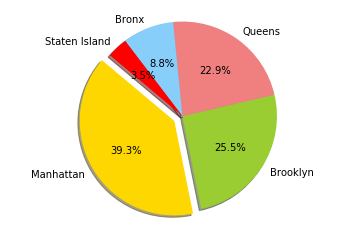

In [14]:
# Data to plot
labels = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']
sizes = [389, 252, 227, 87,35]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red']
explode = (0.1, 0, 0, 0,0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [15]:
nyc_data['categories'].value_counts()

american          218
casual            214
asia_pacific      192
euro              145
latin             121
drink_dessert      75
middle_eastern     28
african             1
Name: categories, dtype: int64

 Among the five boroughs, Manhattan has the largest number of restaurants, followed by Brooklyn and Queens. The most popular type of cuisine/restaurant are American, Casual, and Asia Pacific.

### The sanitary problem

#### Grading Letter 

80% of the restaurants received A grade. 
13 restaurants does not received grading yet
9 restaurants is pending.

In [17]:
#By food categories
pd.crosstab(nyc_data.categories, nyc_data.grade)

grade,A,B,C,N,P,Z
categories,,,,,,
african,1,0,0,0,0,0
american,187,20,4,2,2,3
asia_pacific,146,27,10,1,2,6
casual,178,22,2,7,2,3
drink_dessert,66,8,0,1,0,0
euro,112,20,9,2,2,0
latin,84,26,7,0,1,3
middle_eastern,21,5,2,0,0,0


In [18]:
#By borough
pd.crosstab(nyc_data.boro, nyc_data.grade)

grade,A,B,C,N,P,Z
boro,,,,,,
Bronx,74,18,6,0,2,4
Brooklyn,205,27,11,3,2,5
Manhattan,322,41,10,6,4,2
Queens,175,39,8,4,1,3
Staten Island,27,3,0,0,0,1


In [19]:
nyc_data["score"]=nyc_data["score"].astype(str).astype(int)
nyc_data["grade"]=nyc_data["grade"].astype(str)
nyc_data.dtypes

boro                     object
building                 object
camis                    object
critical_flag            object
cuisine_description      object
dba                      object
grade                    object
lat                      object
lng                      object
score                     int64
violation_description    object
zipcode                  object
categories               object
dtype: object

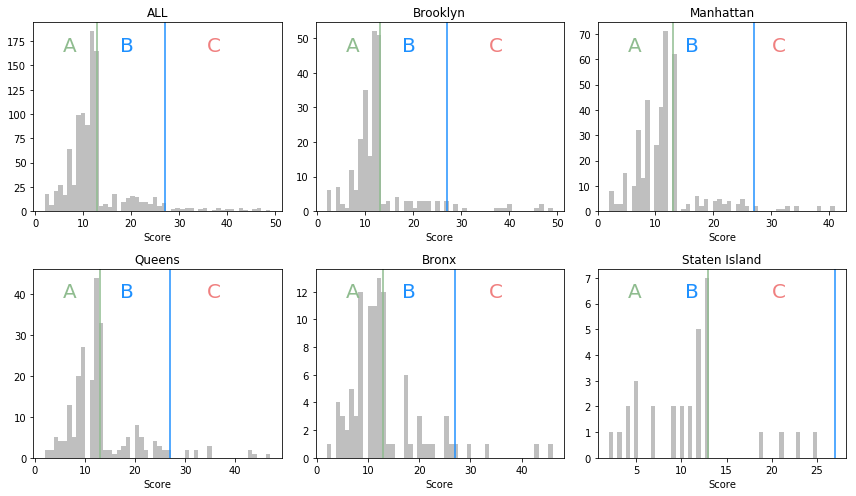

In [20]:
# Define colors to be used in visualizations
colors = {"A": "darkseagreen", "B": "dodgerblue", "C": "lightcoral", "P": "wheat", "Z": "lightgrey", "N": "lightgrey"}

# Bar graph based on scores, segmented by grade
f, axes = plt.subplots(nrows=2,ncols=3,figsize=(12,7))

axes[0][0].hist(nyc_data[(nyc_data.score > 0) & (nyc_data.score < 50)].score,bins=50, color="grey",alpha=0.5)
axes[0][0].set_title("ALL")

for ax, boro in zip(axes.ravel()[1:], nyc_data.boro.unique()):
    ax.hist(nyc_data[(nyc_data.score > 0) & (nyc_data.score < 50) & (nyc_data.boro == boro)].score,bins=50, color="grey",alpha=0.5)
    ax.set_title(boro)
    
for ax in axes.ravel():
    ax.axvline(13,color=colors["A"],linestyle="-")
    ax.text(0.12, 0.85,"A",color=colors["A"],transform=ax.transAxes,fontsize=20)
    ax.axvline(27,color=colors["B"],linestyle="-")
    ax.text(0.35, 0.85,"B",color=colors["B"],transform=ax.transAxes,fontsize=20)
    ax.text(0.7, 0.85,"C",color=colors["C"],transform=ax.transAxes,fontsize=20)
    ax.set_xlabel("Score")
    
plt.tight_layout()

American, Asian-Pacific and casual dinnings accounts for the majority of the restaurants in New York City area. 

Majorities of the restaurants maintain the grade A. However, a lot of restaurants are struggling to maintain the A grade as their violation points are in the "dangerous" zone between 10 and 13. 

In all boroughs, over 50% of the restaurants receive critical violation - which indicates those most likely to contribute to foodbone illness. Manhattan and Brooklyn are the two neighborhood boroughs which have more A-rating restaurants than the other boroughs do. 


#### Number of violations (score)

Display the average scored based on zip code, it shows that all restaurants have at least 2 violations. 
Over 50% of the restaurants have less than 13 violations.
Some restaurants received 98 violations.

Areas with zipcode 10005 (Lower Manhattan) and 10475 (Northeast Bronx) are the two areas has the worst violation score. The average score are over 23 (grade C equivalent)

In [21]:
nyc_data['score'].describe()

count    1003.000000
mean       12.907278
std         7.911838
min         2.000000
25%         9.000000
50%        12.000000
75%        13.000000
max        98.000000
Name: score, dtype: float64

In [22]:
g1 = nyc_data.groupby( [ "zipcode"] ).mean().reset_index()
print(g1.shape)
g1.head()

(165, 2)


,zipcode,score
0,10001,12.052632
1,10002,9.777778
2,10003,11.576923
3,10004,12.166667
4,10005,31.000000


In [23]:
g1.describe()

,score
count,165.000000
mean,13.076375
std,4.031171
min,4.500000
25%,10.714286
50%,12.285714
75%,14.666667
max,31.000000


In [24]:
bad =g1.score > 28
g1[bad]

,zipcode,score
4,10005,31.0
75,10475,30.0


In [25]:
good =g1.score < 5
g1[good]

,zipcode,score
48,10308,4.5


### Violation Description

### The Critical Condition

In [26]:
flag = pd.crosstab(nyc_data.boro, nyc_data.critical_flag)
flag['%Critical']=flag['Y']/(flag['N']+flag['Y'])*100
flag

critical_flag,N,Y,%Critical
boro,,,
Bronx,47,57,54.807692
Brooklyn,150,103,40.711462
Manhattan,184,201,52.207792
Queens,104,126,54.782609
Staten Island,19,12,38.709677


### The violoation type

Using WordCloud to conduct textual analytics

In [27]:
!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Solving environment: done

# All requested packages already installed.

Wordcloud is installed and imported!


In [29]:
stopwords = set(STOPWORDS)

In [30]:
lst_v_dsc = nyc_data['violation_description'].tolist()

word_string = " ".join(str(s) for s in lst_v_dsc)

wordcloud = WordCloud(background_color='white', max_words=2000,stopwords=stopwords).generate(word_string)

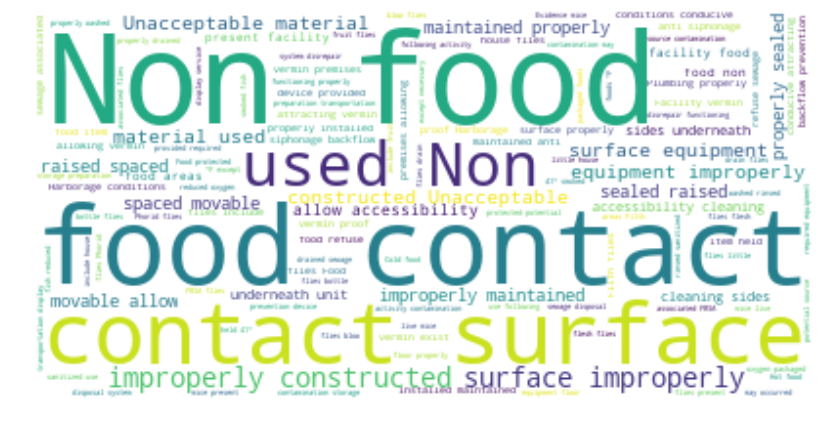

In [31]:
stopwords.add('Moderate risk') # add the words said to stopwords
stopwords.add('risk')
stopwords.add('Moderate')
# re-generate the word cloud
wordcloud.generate(word_string)

fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

# display the cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The main reasons for violation is related to "food contact", "used nonsurface properly", "imporperly contruct", etc.

### Use Foursquare API to generate customer preference

We use API to generate customer's favorablity (likes) on restaurants and explore whether the food type have an impact on their preference.

In [61]:
CLIENT_ID = '###
CLIENT_SECRET = '###
VERSION = '20180605'

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)


LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 5000 # define radius

#New York City  coordinates
ll= 40.7128,-74.0060
lat = 40.7128
lng= -74.0060

#Create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    lng, 
    radius, 
    LIMIT)

#print(url)

In [62]:
# scrape the data from the generated URL

results = requests.get(url).json()
results

# extract the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
#record the data    
    
venues = results['response']['groups'][0]['items']
nyc_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 
                    'venue.location.lng', 'venue.id']
nyc_venues =nyc_venues.loc[:, filtered_columns]

# filter the category for each row
nyc_venues['venue.categories'] = nyc_venues.apply(get_category_type, axis=1)

# clean columns
nyc_venues.columns = [col.split(".")[-1] for col in nyc_venues.columns]


print('{} venues were returned by Foursquare.'.format(nyc_venues.shape[0]))

100 venues were returned by Foursquare.


In [63]:
nyc_venues.head(10)

,name,categories,lat,lng,id
0,The Bar Room at Temple Court,Hotel Bar,40.711448,-74.006802,57f0689d498e7d49d9189369
1,Los Tacos No. 1,Taco Place,40.714267,-74.008756,5d5f24ec09484500079aee00
2,Korin,Furniture / Home Store,40.714824,-74.009404,4af5d65ff964a52091fd21e3
3,Aire Ancient Baths,Spa,40.718141,-74.004941,4fbbd9ede4b0756c0d4c2364
4,9/11 Memorial North Pool,Memorial Site,40.712077,-74.013187,58801864cc5b6a14dedce689
5,One World Trade Center,Building,40.713069,-74.013133,4abe7f9ef964a520068e20e3
6,Washington Market Park,Playground,40.717046,-74.011095,4a9bcc2ff964a5203b3520e3
7,9/11 Memorial South Pool,Memorial Site,40.711039,-74.013082,587ffcc3ea29b80cdce3468d
8,Manhatta,New American Restaurant,40.707654,-74.009138,5ada32224f0e584592628c1f
9,SKY TING YOGA,Yoga Studio,40.718124,-74.003051,582dbaabd21e031c1a35423d


In [64]:
nyc_venues['categories'].unique()

array(['Hotel Bar', 'Taco Place', 'Furniture / Home Store', 'Spa',
       'Memorial Site', 'Building', 'Playground',
       'New American Restaurant', 'Yoga Studio', 'Restaurant', 'Park',
       'Salad Place', 'French Restaurant', 'Music Venue', 'Bridge',
       'Wine Bar', 'Salon / Barbershop', 'Volleyball Court',
       'Dance Studio', 'Cocktail Bar', 'Greek Restaurant', 'Plaza',
       'Indie Movie Theater', 'Thai Restaurant', 'Chocolate Shop',
       'Mediterranean Restaurant', 'Gift Shop', 'Hotel',
       'Italian Restaurant', 'Garden', 'Sushi Restaurant', 'Speakeasy',
       'Grocery Store', 'Bookstore', 'Theme Park Ride / Attraction',
       'Snack Place', 'Theater', 'Café', 'Pilates Studio', 'Beach',
       'Jewelry Store', 'Movie Theater', 'Udon Restaurant',
       'Gourmet Shop', 'Club House', 'Scenic Lookout', 'Boxing Gym',
       'Sandwich Place', 'Comedy Club', 'Wine Shop', 'Cycle Studio',
       'Pier', 'Cheese Shop', 'Soccer Field', 'Dog Run',
       'Gym / Fitness Cente

In [74]:
#remove non-food-related venues categories
removal_list = [ 'Furniture / Home Store', 'Spa',
       'Memorial Site', 'Building', 'Playground','Yoga Studio', 'Park',
       'Music Venue', 'Bridge','Salon / Barbershop', 'Volleyball Court',
       'Dance Studio', 'Plaza','Indie Movie Theater', 'Chocolate Shop',
       'Gift Shop', 'Hotel','Garden', 'Speakeasy',
       'Grocery Store', 'Bookstore', 'Theme Park Ride / Attraction', 'Theater','Pilates Studio', 'Beach',
       'Jewelry Store', 'Movie Theater','Beer Store',
       'Gourmet Shop', 'Club House', 'Scenic Lookout', 'Boxing Gym',
       'Comedy Club', 'Wine Shop', 'Cycle Studio',
       'Pier', 'Cheese Shop', 'Soccer Field', 'Dog Run',
       'Gym / Fitness Center', 'Cosmetics Shop', 'Trail',
       'Art Gallery', 'Stationery Store']

nyc_restaurant = nyc_venues[~nyc_venues['categories'].isin(removal_list)]

nyc_restaurant['categories'].unique()

array(['Hotel Bar', 'Taco Place', 'New American Restaurant', 'Restaurant',
       'Salad Place', 'French Restaurant', 'Wine Bar', 'Cocktail Bar',
       'Greek Restaurant', 'Thai Restaurant', 'Mediterranean Restaurant',
       'Italian Restaurant', 'Sushi Restaurant', 'Snack Place', 'Café',
       'Udon Restaurant', 'Sandwich Place', 'Seafood Restaurant',
       'Bagel Shop', 'Ice Cream Shop', 'Tea Room', 'Moroccan Restaurant',
       'Deli / Bodega', 'Bakery', 'Steakhouse', 'Juice Bar'], dtype=object)

In [75]:
url_list = []
like_list = []
json_list = []

for i in list(nyc_restaurant.id):
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list.append(likes)
print(like_list)

nyc_restaurant['likes'] = like_list
print(nyc_restaurant.shape)
nyc_restaurant.head()

[192, 77, 212, 152, 260, 392, 431, 2048, 825, 126, 107, 2492, 80, 1029, 1119, 165, 437, 362, 330, 654, 627, 1851, 66, 606, 1165, 1158, 435, 188, 1400, 428, 248, 217, 69, 46]
(34, 6)


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,name,categories,lat,lng,id,likes
0,The Bar Room at Temple Court,Hotel Bar,40.711448,-74.006802,57f0689d498e7d49d9189369,192
1,Los Tacos No. 1,Taco Place,40.714267,-74.008756,5d5f24ec09484500079aee00,77
8,Manhatta,New American Restaurant,40.707654,-74.009138,5ada32224f0e584592628c1f,212
11,Crown Shy,Restaurant,40.706187,-74.007490,5c883f65f4b525002c0bf2ca,152
13,sweetgreen,Salad Place,40.705626,-74.008282,577c4a4a498e2c214c8f57e1,260


In [76]:
# we can group some cuisines together to make a better categorical variable

asia_pacific = ['Asian Restaurant','Japanese Restaurant','Udon Restaurant','Thai Restaurant','Sushi Restaurant','Shanghai Restaurant']    
        
drink_dessert = ['Coffee Shop','Café','Juice Bar','Bubble Tea Shop','Ice Cream Shop','Dessert Shop','Juice Bar','Tea Room','Snack Place']
        
casual = ['Bakery','Molecular Gastronomy Restaurant','Breakfast Spot','Fast Food Restaurant','Cajun / Creole Restaurant','Bagel Shop','Bakery','Vegetarian / Vegan Restaurant',
       'Vegetarian / Vegan Restaurant','Restaurant','Bagel Shop','Steakhouse','Sandwich Place','Salad Place','Deli / Bodega','Seafood Restaurant']    
        
bar = ['Hotel Bar','Bar','Wine Bar', 'Cocktail Bar','Beer Bar']        
        
euro = ['French Restaurant','Pizza Place','Italian Restaurant','Greek Restaurant','Australian Restaurant','Moroccan Restaurant','Mediterranean Restaurant']        
        
american = ['American Restaurant', 'Burger Joint', 'New American Restaurant']
        
latin = ['Taco Place','Burrito Place','Cuban Restaurant']    
        
middle_eastern = ['Falafel Restaurant']    

  
def conditions(s):
    if s['categories'] in euro:
        return 'euro'
    if s['categories'] in latin:
        return 'latin'
    if s['categories'] in asia_pacific:
        return 'asia_pacific'
    if s['categories'] in casual:
        return 'casual'
    if s['categories'] in american:
        return 'american'
    if s['categories'] in bar:
        return 'bar'
    if s['categories'] in middle_eastern:
        return 'middle_eastern'
    if s['categories'] in drink_dessert:
        return 'drink_dessert'


nyc_restaurant['categories_classified']=nyc_restaurant.apply(conditions, axis=1)
nyc_restaurant

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,name,categories,lat,lng,id,likes,categories_classified
0,The Bar Room at Temple Court,Hotel Bar,40.711448,-74.006802,57f0689d498e7d49d9189369,192,bar
1,Los Tacos No. 1,Taco Place,40.714267,-74.008756,5d5f24ec09484500079aee00,77,latin
8,Manhatta,New American Restaurant,40.707654,-74.009138,5ada32224f0e584592628c1f,212,american
11,Crown Shy,Restaurant,40.706187,-74.007490,5c883f65f4b525002c0bf2ca,152,casual
13,sweetgreen,Salad Place,40.705626,-74.008282,577c4a4a498e2c214c8f57e1,260,casual
14,Le Coucou,French Restaurant,40.719114,-74.000202,57583641498e90001a32e13e,392,euro
20,La Compagnie des Vins Surnaturels,Wine Bar,40.720448,-73.997969,53506fd9498ebca706a7c170,431,bar
24,The Dead Rabbit,Cocktail Bar,40.703051,-74.010992,50bcb93ae4b0efcb4c84d434,2048,bar
25,Kiki's,Greek Restaurant,40.714476,-73.992036,5521c2ff498ebe2368634187,825,euro
28,Wayla,Thai Restaurant,40.718291,-73.992584,5cc4e9d0c876c8002c3010cb,126,asia_pacific


In [77]:
nyc_restaurant.groupby(['categories_classified'])['likes'].mean()


categories_classified
american         685.000000
asia_pacific     292.400000
bar              890.333333
casual           298.888889
drink_dessert    568.000000
euro             987.111111
latin             77.000000
Name: likes, dtype: float64

In [79]:
nyc_restaurant.shape

(34, 7)

American, Asia_Pacific and Bar  are the top three most favorite restaurants in New York City

In [82]:
nyc_restaurant['likes'].mean()

588.0588235294117

In [83]:
print(np.percentile(nyc_restaurant['likes'],50))

377.0


### Create Location Map of Top Favorite Restaurant

The average likes for restaurants are 588 likes. We will plot the top above average restaurants on the NYC to find its location.

In [276]:
top =nyc_restaurant.likes > 588
nyc_restaurant[top]

,name,categories,lat,lng,id,likes,categories_classified
24,The Dead Rabbit,Cocktail Bar,40.703051,-74.010992,50bcb93ae4b0efcb4c84d434,2048,bar
25,Kiki's,Greek Restaurant,40.714476,-73.992036,5521c2ff498ebe2368634187,825,euro
35,Rubirosa Ristorante,Italian Restaurant,40.722706,-73.995957,4cc6222106c25481d7a4a047,2492,euro
42,Chobani,Snack Place,40.725819,-74.000985,50002274e4b0deb8db4eea3b,1029,drink_dessert
44,Russ & Daughters Café,Café,40.719515,-73.989724,5244bd0e11d2d511de3e244e,1119,drink_dessert
75,Sushi Nakazawa,Sushi Restaurant,40.731719,-74.004400,52155e9d11d2c369404df14e,654,asia_pacific
79,Upstate Craft Beer and Oyster Bar,Seafood Restaurant,40.726331,-73.986453,4e41f0822271a90466a0e967,627,casual
80,Buvette,French Restaurant,40.732782,-74.004275,4d0bf7e3f29c236ac675bfe7,1851,euro
83,Via Carota,Italian Restaurant,40.733052,-74.003573,543c7c63498e0a3393da47a2,606,euro
85,L'Artusi,Italian Restaurant,40.733888,-74.005114,4a27289cf964a52062911fe3,1165,euro


In [85]:
top_restaurant=nyc_restaurant[top]
print(top_restaurant.shape)
top_restaurant

(12, 7)


,name,categories,lat,lng,id,likes,categories_classified
24,The Dead Rabbit,Cocktail Bar,40.703051,-74.010992,50bcb93ae4b0efcb4c84d434,2048,bar
25,Kiki's,Greek Restaurant,40.714476,-73.992036,5521c2ff498ebe2368634187,825,euro
35,Rubirosa Ristorante,Italian Restaurant,40.722706,-73.995957,4cc6222106c25481d7a4a047,2492,euro
42,Chobani,Snack Place,40.725819,-74.000985,50002274e4b0deb8db4eea3b,1029,drink_dessert
44,Russ & Daughters Café,Café,40.719515,-73.989724,5244bd0e11d2d511de3e244e,1119,drink_dessert
75,Sushi Nakazawa,Sushi Restaurant,40.731719,-74.004400,52155e9d11d2c369404df14e,654,asia_pacific
79,Upstate Craft Beer and Oyster Bar,Seafood Restaurant,40.726331,-73.986453,4e41f0822271a90466a0e967,627,casual
80,Buvette,French Restaurant,40.732782,-74.004275,4d0bf7e3f29c236ac675bfe7,1851,euro
83,Via Carota,Italian Restaurant,40.733052,-74.003573,543c7c63498e0a3393da47a2,606,euro
85,L'Artusi,Italian Restaurant,40.733888,-74.005114,4a27289cf964a52062911fe3,1165,euro


In [90]:
#New York City location

latitude = 40.7549
longitude= -73.9840

# create map of TORONTO using latitude and longitude values above with folium
nyc_map = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(top_restaurant['lat'], top_restaurant['lng'], top_restaurant['likes']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(nyc_map)  
    
nyc_map

Top favorite restaurants are in Lower Manhattan, West Village, East Village, and Financial Districts (Wall Street)

### 3. Regression Analysis

#### Multiple Linear Regression Model

####  Dataset 1
Since we only have 1 African restaurant out of 1003 restaurants in the dataset, we will exclude this observation in the regression analysis.

In [208]:
nyc_data.drop(nyc_data.index[40])

,boro,building,camis,critical_flag,cuisine_description,dba,grade,lat,lng,score,violation_description,zipcode,categories
0,Brooklyn,1057,50061005,N,American,DIAMOND REEF,A,40.679497045729,-73.956678161648,10,Facility not vermin proof. Harborage or condit...,11238,american
1,Manhattan,1618,41615115,N,Spanish,EL NUEVO CARIDAD RESTAURANT,A,40.855449723566,-73.929230693936,12,Facility not vermin proof. Harborage or condit...,10040,euro
2,Queens,8313,50094666,N,Café/Coffee/Tea,KAPE'T TORTA,A,40.737216817441,-73.879700416899,11,Lighting inadequate; permanent lighting not pr...,11373,drink_dessert
3,Manhattan,1280,40524833,N,Café/Coffee/Tea,STARBUCKS,A,40.779595455676,-73.955518718157,11,Plumbing not properly installed or maintained;...,10028,drink_dessert
4,Queens,8706,50056126,Y,Spanish,RICURAS DEL REY RESTAURANT,B,40.693413597944,-73.852045197056,18,Evidence of mice or live mice present in facil...,11421,euro
5,Manhattan,2519,50101722,Y,Chicken,UNITED FRIED CHICKEN,N,40.822199899469,-73.93864943353,12,Filth flies or food/refuse/sewage-associated (...,10039,casual
6,Bronx,5690,50045596,N,Chinese,NEW CHINA,P,40.905434879643,-73.900843816155,12,Non-food contact surface improperly constructe...,10471,asia_pacific
7,Queens,4910,50008904,N,Filipino,TITO RADS GRILL,A,40.742790547751,-73.915630220862,10,Food contact surface not properly maintained.,11377,asia_pacific
8,Manhattan,149,41468453,Y,American,THE 13TH STEP,A,40.729363268647,-73.987122854337,12,Filth flies or food/refuse/sewage-associated (...,10003,american
9,Queens,13613,41694992,Y,Chinese,IMPERIAL PALACE,C,40.761673794176,-73.830584230826,35,"Sanitized equipment or utensil, including in-u...",11354,asia_pacific


In [211]:
# create dummies for linear regression modelling

# one hot encoding
dataset1 = pd.get_dummies(nyc_data[['categories']], 
                               prefix="", 
                               prefix_sep="")

# add name, ranking, and likes columns back to dataframe
dataset1['score'] = nyc_data['score']
dataset1['dba'] = nyc_data['dba']
dataset1['categories'] = nyc_data['categories']

# move name column to the first column
columns = [dataset1.columns[-1]] + list(dataset1.columns[:-1])
dataset1 = dataset1[columns]


dataset1.head()

,categories,american,asia_pacific,casual,drink_dessert,euro,latin,middle_eastern,score,dba
0,american,1,0,0,0,0,0,0,10,DIAMOND REEF
1,euro,0,0,0,0,1,0,0,12,EL NUEVO CARIDAD RESTAURANT
2,drink_dessert,0,0,0,1,0,0,0,11,KAPE'T TORTA
3,drink_dessert,0,0,0,1,0,0,0,11,STARBUCKS
4,euro,0,0,0,0,1,0,0,18,RICURAS DEL REY RESTAURANT
5,casual,0,0,1,0,0,0,0,12,UNITED FRIED CHICKEN
6,asia_pacific,0,1,0,0,0,0,0,12,NEW CHINA
7,asia_pacific,0,1,0,0,0,0,0,10,TITO RADS GRILL
8,american,1,0,0,0,0,0,0,12,THE 13TH STEP
9,asia_pacific,0,1,0,0,0,0,0,35,IMPERIAL PALACE


In [244]:
# Multiple Linear Regression
import statsmodels.api as sm
msk = np.random.rand(len(dataset1)) < 0.8
train1 = dataset1[msk]
test1 = dataset1[~msk]

x1 = np.asanyarray(train1[['american','asia_pacific','casual','euro','latin','middle_eastern']])
y1 = np.asanyarray(train1[['score']])
model1 = sm.OLS(y1, x1)
results1 = model1.fit()
print(results1.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     268.0
Date:                Sat, 28 Mar 2020   Prob (F-statistic):          1.09e-185
Time:                        17:45:53   Log-Likelihood:                -2806.0
No. Observations:                 786   AIC:                             5624.
Df Residuals:                     780   BIC:                             5652.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            12.2632      0.660     18.589      0.0

In [245]:
# Multiple Linear Regression Prediction Capabilities
x_test1 = np.asanyarray(test1[['american','asia_pacific','casual','euro','latin','middle_eastern']])
y_pred1 =results1.predict(x_test1)
y_test1 = np.asanyarray(test1[['score']])

print("Residual sum of squares: %.2f" % np.mean((y_pred1 - y_test1) ** 2))

Residual sum of squares: 73.03


In [243]:
# Explained variance score: 1 is perfect prediction
print("R2 score: %.2f'" % r2_score(y_test1, y_pred1))
print("MSE score: %.2f'" % mean_squared_error(y_test1, y_pred1))

R2 score: -0.58'
MSE score: 114.36'


#### Dataset 2

In [261]:
# create dummies for linear regression modelling

# one hot encoding
dataset = pd.get_dummies(nyc_restaurant[['categories_classified']], 
                               prefix="", 
                               prefix_sep="")

# add name, ranking, and likes columns back to dataframe
dataset['likes'] = nyc_restaurant['likes']
dataset['name'] = nyc_restaurant['name']
dataset['categories'] = nyc_restaurant['categories']

# move name column to the first column
columns = [dataset.columns[-1]] + list(dataset.columns[:-1])
dataset = dataset[columns]


dataset.head()

,categories,american,asia_pacific,bar,casual,drink_dessert,euro,latin,likes,name
0,Hotel Bar,0,0,1,0,0,0,0,192,The Bar Room at Temple Court
1,Taco Place,0,0,0,0,0,0,1,77,Los Tacos No. 1
8,New American Restaurant,1,0,0,0,0,0,0,212,Manhatta
11,Restaurant,0,0,0,1,0,0,0,152,Crown Shy
13,Salad Place,0,0,0,1,0,0,0,260,sweetgreen


American, European and Bar are the most favorable kind of restaurants. We will use the variables as the independent variables.

In [271]:
# Multiple Linear Regression
import statsmodels.api as sm
msk = np.random.rand(len(dataset)) < 0.8
train = dataset[msk]
test = dataset[~msk]

x = np.asanyarray(train[['american','bar','euro']])
y = np.asanyarray(train[['likes']])
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     13.42
Date:                Sat, 28 Mar 2020   Prob (F-statistic):           3.41e-05
Time:                        17:52:25   Log-Likelihood:                -191.73
No. Observations:                  25   AIC:                             389.5
Df Residuals:                      22   BIC:                             393.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1158.0000    552.402      2.096      0.0

In [272]:
# Multiple Linear Regression Prediction Capabilities
x_test = np.asanyarray(test[['american','bar','euro']])
y_pred =results.predict(x_test)
print(y_pred)
y_test = np.asanyarray(test[['likes']])

print("Residual sum of squares: %.2f" % np.mean((y_pred - y_test) ** 2))
                                        

[1239.5 1158.     0.  1254.8    0.     0.  1254.8 1254.8 1254.8]
Residual sum of squares: 729931.01


In [273]:
# Explained variance score: 1 is perfect prediction
print("R2 score: %.2f'" % r2_score(y_test, y_pred))
print("MSE score: %.2f'" % mean_squared_error(y_test, y_pred))

R2 score: -1.53'
MSE score: 762735.60'


Both regression models are not the good prediction of likes and violation score. 
The kind of food do have a significant impact on customers' preference (likes) and violation scores. However, there are not the only variables to predict the customers preference toward the store

## 4. Results

The restaurant market in New York City is very competitive. Majority of restaurants are in Manhattan or Brooklyn area. 

#### Sanitary Regulation

Only one half of the restaurants in the city has a grade A, and many of them are on the verge between grade A and B. Restaurants in Lower Manhattan and Northeast Bronx often failed to meet the grade A quality.

#### Customer Preference

American, European, and Bar are highly favorable cuisine. The most favorable restaurants are located in West Village and East Village -- which are also the famous "dining" neighborhoods with a lot of restaurants -- and Lower Manhattan.

With the presence of highly favorable restaurants, Lower Manhattan has a lot of growing potential to become the new "restaurant" district. However, the neighborhood needs to put much effort on improving its sanitary quality.

City planner can consider implements benefits to attract investors open new restaurant business in the area. At the same time, they should have some program to improve the quality of facility, water, and workers here.